# Assignment 4 - Tutorial notebook

Simple analytical model        

__41934 - Advanced BIM, E23__

Kaare G. S. Hansen, s214282 - DTU


Documentation for `PyConBIM`, the package that I made, is found at [PyConBIM](https://kaareh.github.io/DTU_E23_41934_Advanced-BIM/_autosummary/pyconbim.html).

Please refer to this documentaion, while going through this. Source code should explain further.

This tutorial (which includes the whole webiste, not only this notebook), is targeted towards **level-3**.

## Imports

In [1]:
import sys
import os
import loguru as logger

In [2]:
import pyconbim.geomUtils as geomUtils
import pyconbim.ifcUtils as ifcUtils
import pyconbim.modelPreprocessor as modelPP
from pyconbim.rendering import *
import pyconbim.utils as utils
import pyconbim.analyticalModel as analyticalModel

## Load models

In [3]:
models = ifcUtils.load_models(model_dir='../models',
                     models={
                         'simple-frame-with-slab-wall': 'simple-frame-with-slab-wall.ifc',
                         'LLYN - STRU': 'LLYN - STRU.ifc',
                        #  'ark': 'LLYN - ARK.ifc',
                             })
model = models['simple-frame-with-slab-wall']

2023-11-26 23:01:05.790 | INFO     | pyconbim.ifcUtils:load_models:77 - File path, simple-frame-with-slab-wall: ../models\simple-frame-with-slab-wall.ifc
2023-11-26 23:01:05.820 | INFO     | pyconbim.ifcUtils:load_models:79 - Model schema: IFC4

2023-11-26 23:01:05.821 | INFO     | pyconbim.ifcUtils:load_models:77 - File path, LLYN - STRU: ../models\LLYN - STRU.ifc
2023-11-26 23:01:06.236 | INFO     | pyconbim.ifcUtils:load_models:79 - Model schema: IFC4



## Geometry analysis

Ifc-axis may not be usable.

### False axis

We cannot necessarily depend on the representations and geometry that is directly provided by the model.

In `LLYN - STRU.ifc`, there happens to be some axis representations that do not correspond properly with their actual body representaion.

First we load our model:

In [4]:
model = models['LLYN - STRU']
modelData = ifcUtils.ModelData(model)

2023-11-26 23:01:06.251 | INFO     | pyconbim.ifcUtils:processGeometry:120 - Beginning processing with 12 threads...
2023-11-26 23:01:06.337 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 0%
2023-11-26 23:01:06.539 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 22%
2023-11-26 23:01:06.766 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 29%
2023-11-26 23:01:07.938 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 44%
2023-11-26 23:01:09.665 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 57%
2023-11-26 23:01:11.111 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 100%
2023-11-26 23:01:11.257 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 100%
2023-11-26 23:01:11.339 | INFO     | pyconbim.ifcUtils:processGeometry:131 - Progress: 100%
2023-11-26 23:01:11.355 | INFO     | pyconbim.ifcUtils:processGeometry:152 - Processed 3601 items
2023-11-26 23:01:11.356 | INFO     | pyconbim.ifcUtils:

Now we will have a look at one of the beams at the roof, specifically the beam with GUID `0b06gcHN58zxrRFHHpcInr`. Feel free to explore this in the fully loaded model for yourself.

This beam happens to have an incorrect axis. It has two representations: `Body` and `Axis`:

In [5]:
beam = model.by_guid('0b06gcHN58zxrRFHHpcInr')
shapes = modelData.shapes[beam.GlobalId]
shapes

{'Axis': shape_tuple(data=<ifcopenshell.ifcopenshell_wrapper.SerializedElement; proxy of <Swig Object of type 'IfcGeom::SerializedElement *' at 0x0000016631BAD320> >, geometry=<class 'TopoDS_Compound'>, styles=((-1.0, -1.0, -1.0, 1.0),), style_ids=(-1,)),
 'Body': shape_tuple(data=<ifcopenshell.ifcopenshell_wrapper.SerializedElement; proxy of <Swig Object of type 'IfcGeom::SerializedElement *' at 0x00000166381B0D50> >, geometry=<class 'TopoDS_Compound'>, styles=((1.0, 0.5019607843137255, 0.25098039215686274, 1.0),), style_ids=(3340,))}

Next we will render these representations:

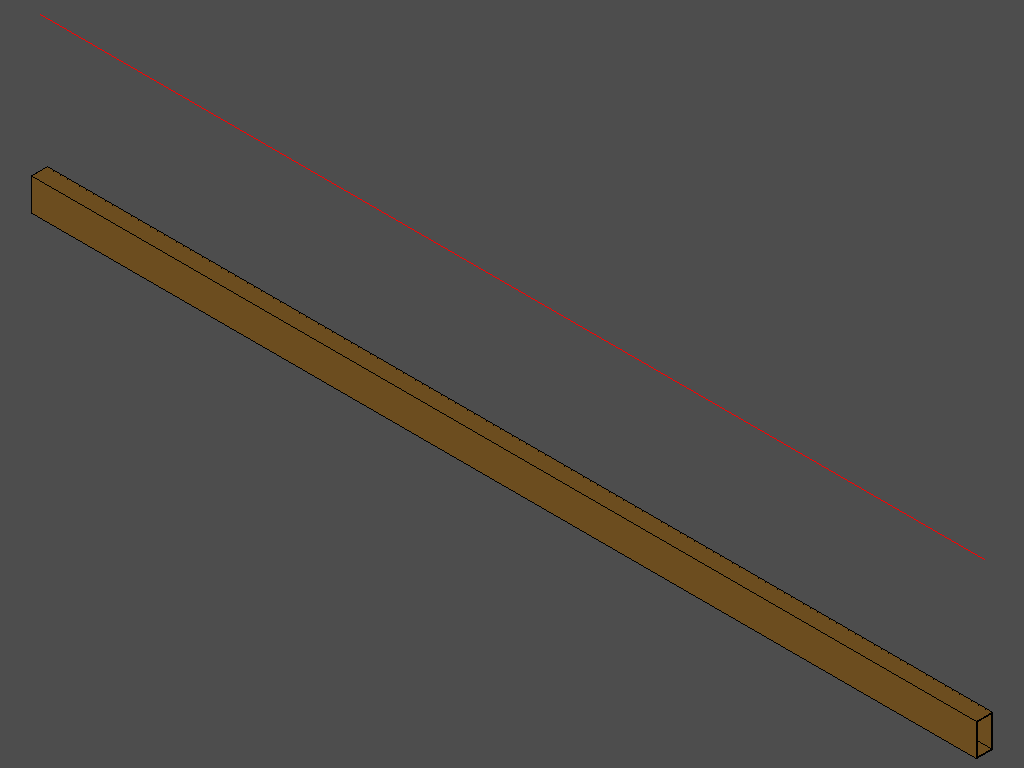

In [6]:
body = shapes['Body'].geometry
axis = shapes['Axis'].geometry
RenderImage(SimpleRenderFunc, modelData=modelData, shapes=[body, axis], size=(100, 800))

As clearly visible in the rendering above, either the `Body` or `Axis` representation is wrong.

Which is actually correct is unknown. However, we decide to "trust" the `Body`, as it is more likely to be caught by visual inspection if wrong.
A warning should be omitted whenever representations do not correspond with each other.

This is just one of many examples. There are also elements with their axis located in the world-origin, while the element is in a entirely different location.

### Oriented bounding box

Now we will find the axis by the oriented bounding box of the element.

When the OBB is found, the longest direction of the box will be chosen, and considered the axis. It is located in the center of mass of the OBB.

Below is the original axis and the axis found by this analysis-method:

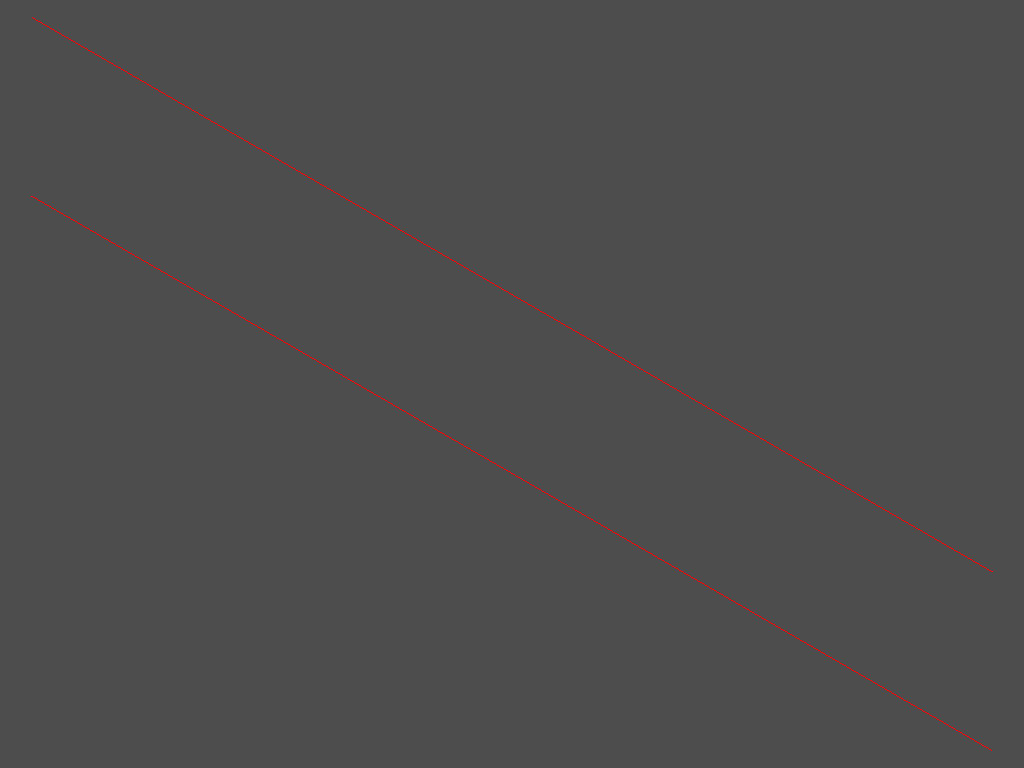

In [7]:
body = shapes['Body'].geometry
axis = shapes['Axis'].geometry
OBB = modelData.obbs[beam.GlobalId]
OBBShp = geomUtils.convert_bnd_to_shape(OBB)
line = geomUtils.convert_bnd_to_line(OBB, returnWire=True)
RenderImage(SimpleRenderFunc, modelData=modelData, shapes=[axis, line], size=(1000, 800))

## Whole model analyzed by OBB-method

Now we will find the idealized shapes for the whole model. This is curves for entities like beams and columns, and surfaces for entities like walls and slabs.

At the moment, this tool is restricted to lines instead of curves, and only planar surfaces.

According to an input file, the model is altered before further analysis

In [8]:
modelPP.preProcessModel(modelData, '../input/LLYN-corrections.json')

2023-11-26 23:01:14.354 | INFO     | pyconbim.modelPreprocessor:preProcessModel:86 - Preprocessing model...
2023-11-26 23:01:14.354 | DEBUG    | pyconbim.modelPreprocessor:alter_loadBearing:33 - #37491=IfcPropertySet('1G3Z63FxGGsMln1b_bk6S1',#18,'Pset_WallCommon',$,(#336,#387,#391,#592))
2023-11-26 23:01:14.564 | DEBUG    | pyconbim.modelPreprocessor:alter_loadBearing:33 - #6919=IfcPropertySet('2yuI_rMvH2WGuYNr7UECFD',#18,'Pset_WallCommon',$,(#336,#387,#391,#592))
2023-11-26 23:01:14.565 | DEBUG    | pyconbim.modelPreprocessor:alter_loadBearing:33 - #682=IfcPropertySet('3hRKdzubwros13xM7Z41Ir',#18,'Pset_WallCommon',$,(#336,#387,#391,#592))
2023-11-26 23:01:14.567 | DEBUG    | pyconbim.modelPreprocessor:alter_loadBearing:33 - #593=IfcPropertySet('258pTMLajWWyHTsB4fxe7_',#18,'Pset_WallCommon',$,(#336,#387,#391,#592))
2023-11-26 23:01:14.568 | DEBUG    | pyconbim.modelPreprocessor:alter_loadBearing:33 - #10539=IfcPropertySet('1WEvIrcoJaMnuUpTOdSs45',#18,'Pset_WallCommon',$,(#188,#391,#592

First we gather all elements of interest:

In [9]:
logger.disable("pyconbim.geomUtils")

elements = modelData.get_structuralMembers()

2023-11-26 23:01:15.888 | INFO     | pyconbim.ifcUtils:getLoadBearing:92 - Number of load-bearing elements: 1760
2023-11-26 23:01:15.888 | INFO     | pyconbim.ifcUtils:getLoadBearing:93 - Unique types of loadbearing elements:
 {'IfcSlab', 'IfcBeam', 'IfcWall', 'IfcColumn'}


Next the analytical model is created. This includes the structural elements as idealized geometry:

In [10]:
aModel = AnalyticalModel()
aModel.add_elements(elements, modelData)
aModel.solve_connections()
aModel.merge_nodes()

2023-11-26 23:01:34.188 | INFO     | pyconbim.analyticalModel:add_elements:499 - Added 1760/1760 members to analytical model.
2023-11-26 23:01:34.188 | INFO     | pyconbim.analyticalModel:solve_connections:583 - Solving connections...
2023-11-26 23:01:35.523 | DEBUG    | pyconbim.analyticalModel:solve_connections:589 - Collision pairs: 4946
2023-11-26 23:01:37.061 | DEBUG    | pyconbim.analyticalModel:merge_nodes:639 - Merging 6044 nodes...
2023-11-26 23:01:46.673 | DEBUG    | pyconbim.analyticalModel:merge_nodes:650 - Merged 6044 to 1707 nodes...


Below is a render of the analytical model:

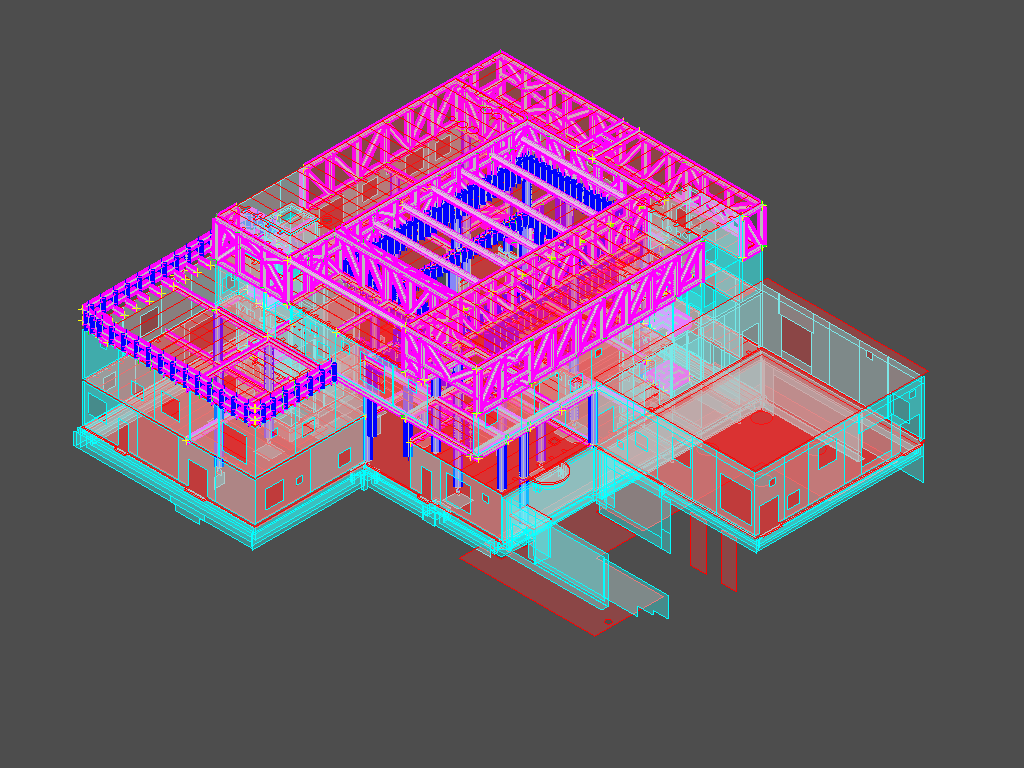

In [11]:
# RenderInWindow(RenderStructuralMembersFunc, modelData=modelData, analyticalModel=aModel, size=(1000, 800))
RenderImage(RenderStructuralMembersFunc, modelData=modelData, analyticalModel=aModel, size=(1000, 800))

### Exporting the structural analysis model

The structural analysis model does currently not exist in the model as IFC-entities, but only as objects in `PyConBIM`.

Now, these objects will added to the IFC-model.

https://ifc43-docs.standards.buildingsmart.org/IFC/RELEASE/IFC4x3/HTML/lexical/IfcStructuralAnalysisModel.htm

In [12]:
aModel.to_ifc_analysisModel(modelData.model)

2023-11-26 23:04:54.222 | INFO     | pyconbim.analyticalModel:to_ifc_analysisModel:439 - Point connections: 1707
2023-11-26 23:04:54.222 | INFO     | pyconbim.analyticalModel:to_ifc_analysisModel:440 - Curve members: 1016
2023-11-26 23:04:54.222 | INFO     | pyconbim.analyticalModel:to_ifc_analysisModel:441 - Surface members: 744


#71719=IfcStructuralAnalysisModel('19TVPcVD1AOQYU03nZMYJ6',#71718,$,$,$,.LOADING_3D.,$,$,$,$)

In this configuration, all the structural analysis items will be added to the same model as the original - that is, all objects present in the input model, will be present in the output model.

The updated model can then be written to disk by:

`pyconbim.ifcUtils.writeToFile(modelData.model, outputFileName)`

where `outputFileName` is preferably not the same as the loaded model.